Yadukrishnan - 21BAI1210

In [1]:
#Ignoring TF GPU warning messages
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import random
import cv2
import numpy as np
import pandas as pd
import innvestigate as inv
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K

from tensorflow import keras 
from tensorflow.keras import (layers, Model)
from tensorflow.keras.losses import Loss
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import (Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Flatten)

/home/yaduk/anaconda3/envs/xai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datadir = "dataset/"
ImagesDir = os.path.join(datadir, "Images")
MasksDir = os.path.join(datadir, "Masks")
img_size = (256,256)
num_classes = 2
batch_size = 16

In [4]:
def createDataset(Images, Masks):
    Images = filter(lambda img: img.endswith(".tif"), Images)
    Masks = filter(lambda img: img.endswith(".TIF"), Masks)
#     print(list(Masks))
    Images = map(lambda img: os.path.join(ImagesDir, img), Images)
    Masks = map(lambda imag: os.path.join(MasksDir, imag), Masks)
#     print(list(Masks))
    Images = sorted(Images)
    Masks = sorted(Masks)
    
    return Images, Masks

In [5]:
dataset = createDataset(os.listdir(ImagesDir), os.listdir(MasksDir))

dataset/Images/ytma10_010704_benign1_ccd.tif
(768, 896, 3)


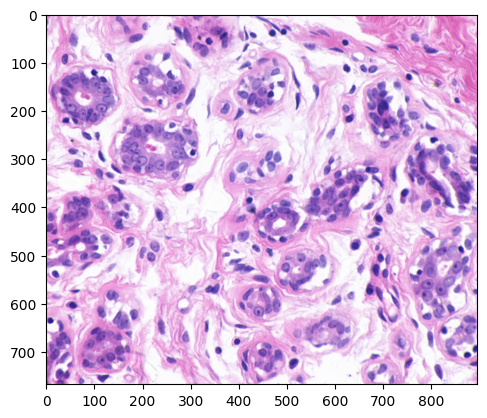

In [6]:
image = imread(dataset[0][0])
mask = imread(dataset[1][0])
print(dataset[0][0])
plt.imshow(image)
print(image.shape)
# plt.imshow(mask)

(768, 896)
255


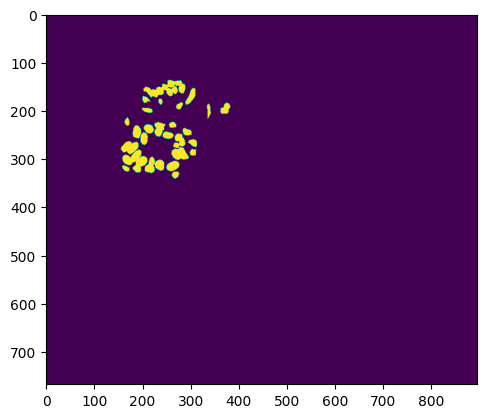

In [7]:
plt.imshow(mask)
print(mask.shape)
print(np.max(mask))

In [8]:
dataset = pd.DataFrame(dataset).T

In [9]:
imageList = list(dataset[0])
maskList = list(dataset[1])
len(imageList)

58

In [10]:
class CancerDataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            image = imread(path)
#             print(image.shape)
#             imshow(image)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, img_size)
            image = image/255.0
            x[j] = image
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            image = imread(path)
#             //print(image.shape)
#             imshow(image)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, img_size)
    
#             print(image.shape)
#             imshow(image)
#             image = keras.utils.to_categorical(image, axis = -1)
            image = np.expand_dims(image, axis = -1)
            image = image/255.0
            y[j] = image
        return x, y

In [11]:
def get_model(weights = None, flatten = False, last_activation="sigmoid"):
    inputs = Input((256, 256, 3))
    # Change integer to float and also scale pixel values

    # Contraction/Encoder path
    # Block 1
    c1 = Conv2D(filters=16, kernel_size=(3,3),
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(filters=16, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2,2))(c1)
    # Block 2
    c2 = Conv2D(filters=32, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(filters=32, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2,2))(c2)
    # Block 3
    c3 = Conv2D(filters=64, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(filters=64, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2,2))(c3)
    # Block 4
    c4 = Conv2D(filters=128, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(filters=128, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)
    # Block 5
    c5 = Conv2D(filters=256, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(filters=256, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c5)

    # Expansion/Decoder path
    # Block 6
    u6 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides = (2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(filters=128, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(filters=128, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c6)

    # Block 7
    u7 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides = (2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(filters=64, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(filters=64, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c7)

    # Block 8
    u8 = Conv2DTranspose(filters=32, kernel_size=(2,2), strides = (2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(filters=32, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(filters=32, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c8)

    # Block 9
    u9 = Conv2DTranspose(filters=16, kernel_size=(2,2), strides = (2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(filters=16, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(filters=16, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c9)
    # Outputs
    outputs = Conv2D(filters=1, kernel_size=(1,1), 
                                activation=last_activation)(c9)
    
    if(flatten):
        outputs = Flatten()(outputs)
        
    model = Model(inputs=[inputs], outputs=[outputs])
    
    if weights is not None:
        model.load_weights(weights)
    return model

model = get_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [12]:
val_samples = 6 # 85% Training -- 15% Validation
random.Random(1822).shuffle(imageList)
random.Random(1822).shuffle(maskList)
print(imageList[0])
print(maskList[0])
train_input_img_paths = imageList[:-val_samples]
train_target_img_paths = maskList[:-val_samples]
print(train_input_img_paths[0], train_target_img_paths[0])
val_input_img_paths = imageList[-val_samples:]
val_target_img_paths = maskList[-val_samples:]

# Instantiate data Sequences for each split
train_gen = CancerDataset(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = CancerDataset(6, img_size, val_input_img_paths, val_target_img_paths)

dataset/Images/ytma12_010804_malignant3_ccd.tif
dataset/Masks/ytma12_010804_malignant3.TIF
dataset/Images/ytma12_010804_malignant3_ccd.tif dataset/Masks/ytma12_010804_malignant3.TIF


In [13]:
# Loss function
def bce_loss(y_true,y_pred):
    y_true=K.cast(y_true,'float32')
    y_pred=K.cast(y_pred,'float32')
    return tf.keras.losses.binary_crossentropy(y_true,y_pred)
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coef_v = (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)
    return dice_coef_v
def dice_loss(y_true, y_pred):
    dice_loss_v = 1 - dice_coef(y_true, y_pred)
    return dice_loss_v
def bce_dice_loss(y_true, y_pred):
    bce_dice_loss_v = bce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return bce_dice_loss_v

In [14]:
optimizer = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer="adam", loss=bce_dice_loss, metrics=[dice_coef])

callbacks = [
    keras.callbacks.ModelCheckpoint("cancerSegmentation.h5", save_best_only=True)
]

epochs = 300

In [15]:
#modelunet=model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

In [16]:
#model.save("unet_breast_cancer.h5")
#model.save_weights("unet_breast_cancer.weights.h5")

In [17]:
model = tf.keras.models.load_model("unet_breast_cancer.h5", custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef})

In [18]:
val_image = imageList[:6]
val_mask = maskList[:6]
val_gen = CancerDataset(6, img_size, val_image, val_mask)
val_preds = model.predict(val_gen)

1/1 [==============================] - 1s 588ms/step


In [19]:
temp_image = imageList[:58]
temp_mask = maskList[:58]
temp_gen = CancerDataset(58, img_size, temp_image, temp_mask)
temp_preds = model.predict(temp_gen)

1/1 [==============================] - 1s 1s/step


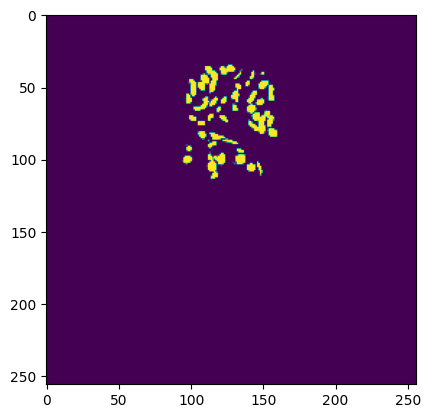

In [20]:
""" fig = plt.figure(figsize=(15, 6))
columns = 14
rows = 4
h = 10
w = 10
for i in range(1, columns*rows + 1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(temp_preds[i-1])
plt.show() """
plt.imshow(temp_preds[6])

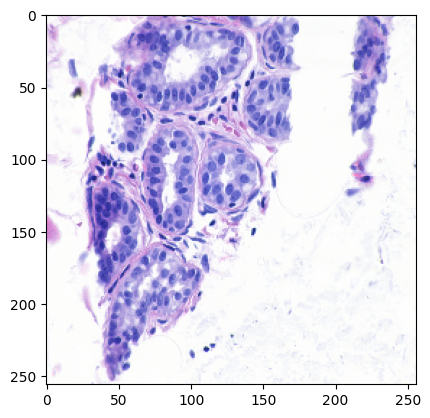

In [21]:
""" fig = plt.figure(figsize=(15, 6))
columns = 14
rows = 4
h = 10
w = 10
for i in range(1, columns*rows + 1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(temp_gen.__getitem__(0)[0][i-1])
plt.show() """
plt.imshow(temp_gen.__getitem__(0)[0][6])

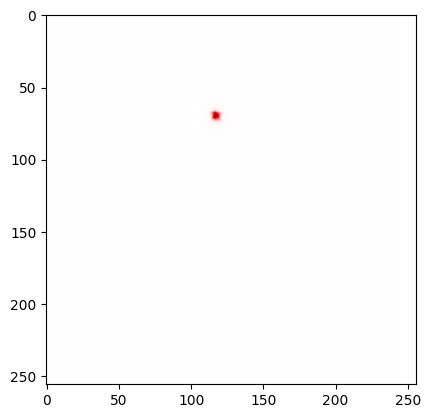

In [25]:
# modelWithoutSigmoid = inv.model_wo_output_activation(model)
""" tf.compat.v1.disable_eager_execution()
modelWithFlatten = get_model("unet_breast_cancer.weights.h5", flatten=True, last_activation="linear")
analyser = inv.create_analyzer("deep_taylor", modelWithFlatten)

fig = plt.figure(figsize=(15, 6))
columns = 14
rows = 4
h = 10
w = 10
for i in range(1, columns*rows + 1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    
    x = np.expand_dims(temp_gen.__getitem__(0)[0][4], axis = 0)
    a = analyser.analyze(x)
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))
    plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.show() """
tf.compat.v1.disable_eager_execution()
modelWithFlatten = get_model("unet_breast_cancer.weights.h5", flatten=True, last_activation="linear")
analyser = inv.create_analyzer("deep_taylor", modelWithFlatten)

x = np.expand_dims(temp_gen.__getitem__(0)[0][6], axis = 0)
a = analyser.analyze(x)
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

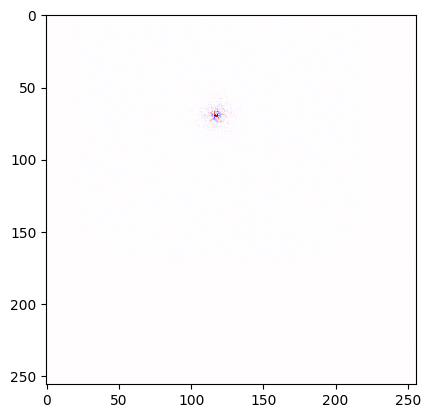

In [26]:
""" fig = plt.figure(figsize=(15, 6))
columns = 14
rows = 4
h = 10
w = 10
for i in range(1, columns*rows + 1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    
    analyser = inv.create_analyzer("lrp.epsilon", modelWithFlatten)
    x = np.expand_dims(temp_gen.__getitem__(0)[0][i-1], axis = 0)

    a = analyser.analyze(x)
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))
    plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.show() """
analyser = inv.create_analyzer("lrp.epsilon", modelWithFlatten)
x = np.expand_dims(temp_gen.__getitem__(0)[0][6], axis = 0)

a = analyser.analyze(x)
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

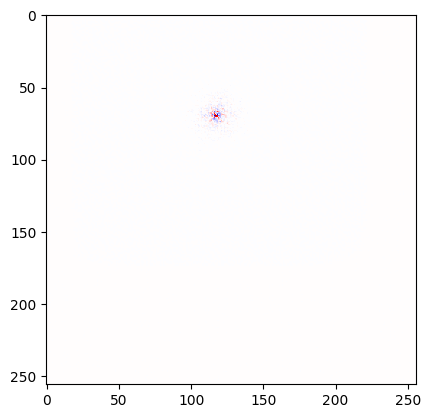

In [27]:
""" fig = plt.figure(figsize=(15, 6))
columns = 14
rows = 4
h = 10
w = 10
for i in range(1, columns*rows + 1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    
    analyser = inv.create_analyzer("lrp.z", modelWithFlatten)
    x = np.expand_dims(temp_gen.__getitem__(0)[0][i-1], axis = 0)

    a = analyser.analyze(x)
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))
    plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.show() """

analyser = inv.create_analyzer("lrp.z", modelWithFlatten)
x = np.expand_dims(temp_gen.__getitem__(0)[0][6], axis = 0)

a = analyser.analyze(x)
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))